In [31]:
# Library Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import openai
from openai import OpenAI, AzureOpenAI

import requests
from bs4 import BeautifulSoup
from bs4.element import Comment

from utils import load_txt, cprint, MetricsTracker

In [93]:
# LLM Agent
def get_openai_client(use_azure=False):
    if use_azure:
        client = AzureOpenAI(
            azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
            api_key=os.getenv("AZURE_OPENAI_KEY"),
            api_version="2024-05-01-preview"
        )
    else:
        client = OpenAI(
            api_key=os.getenv("OPENAI_API_KEY")
        )
    return client

def llm(prompt, model="gpt-4o-mini", stop=["\n"], use_azure=False, max_retries=3, wait_time=5):
    client = get_openai_client(use_azure)
    
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "system", "content": prompt}],
                temperature=0,
                max_tokens=100,
                top_p=1,
                frequency_penalty=0.0,
                presence_penalty=0.0,
                stop=stop
            )
            content = response.choices[0].message.content
            
            if content is None or content.strip() == "":
                print(f"Attempt {attempt + 1}: Empty response from LLM. Retrying...")
                continue  # Try again instead of raising an error
            
            # Post-process to ensure we stop at the first occurrence of any stop sequence
            for stop_seq in stop:
                index = content.find(stop_seq)
                if index != -1:
                    content = content[:index]
            
            return content.strip()
        
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                print(f"Waiting for {wait_time} seconds before retrying...")
                time.sleep(wait_time)
            else:
                print("All attempts failed. Returning default action.")
                return ""
    
    print("All attempts returned empty. Returning default action.")
    return ""

In [94]:
# webshop utils

WEBSHOP_URL = "http://127.0.0.1:3000" # Change for your own webshop url
ACTION_TO_TEMPLATE = {
    'Description': 'description_page.html',
    'Features': 'features_page.html',
    'Reviews': 'review_page.html',
    'Attributes': 'attributes_page.html',
}

def clean_str(p):
  return p.encode().decode("unicode-escape").encode("latin1").decode("utf-8")


def tag_visible(element):
    ignore = {'style', 'script', 'head', 'title', 'meta', '[document]'}
    return (
        element.parent.name not in ignore and not isinstance(element, Comment)
    )


def webshop_text(session, page_type, query_string='', page_num=1, asin='', options={}, subpage='', **kwargs):
    if page_type == 'init':
      url = (
          f'{WEBSHOP_URL}/{session}'
      )
    if page_type == 'search':
      url = (
          f'{WEBSHOP_URL}/search_results/{session}/'
          f'{query_string}/{page_num}'
      )
    elif page_type == 'item':
      url = (
          f'{WEBSHOP_URL}/item_page/{session}/'
          f'{asin}/{query_string}/{page_num}/{options}'
      )
    elif page_type == 'item_sub':
      url = (
          f'{WEBSHOP_URL}/item_sub_page/{session}/'
          f'{asin}/{query_string}/{page_num}/{subpage}/{options}'
      )
    elif page_type == 'end':
      url = (
          f'{WEBSHOP_URL}/done/{session}/'
          f'{asin}/{options}'
      )
    # print(url)
    html = requests.get(url).text
    html_obj = BeautifulSoup(html, 'html.parser')
    texts = html_obj.findAll(text=True)
    visible_texts = list(filter(tag_visible, texts))
    # visible_texts = [str(text).strip().strip('\\n') for text in visible_texts]
    # if page_type == 'end': import pdb; pdb.set_trace()
    if False:
        # For `simple` mode, return just [SEP] separators
        return ' [SEP] '.join(t.strip() for t in visible_texts if t != '\n')
    else:
        # Otherwise, return an observation with tags mapped to specific, unique separators
        observation = ''
        option_type = ''
        options = {}
        asins = []
        cnt = 0
        prod_cnt = 0
        just_prod = 0
        for t in visible_texts:
            if t == '\n': continue
            if t.replace('\n', '').replace('\\n', '').replace(' ', '') == '': continue
            # if t.startswith('Instruction:') and page_type != 'init': continue
            # print(t.parent.name, t)
            if t.parent.name == 'button':  # button
                processed_t = f'\n[{t}] '
            elif t.parent.name == 'label':  # options
                if f"'{t}'" in url:
                    processed_t = f'[[{t}]]'
                    # observation = f'You have clicked {t}.\n' + observation
                else:
                    processed_t = f'[{t}]'
                options[str(t)] = option_type
                # options[option_type] = options.get(option_type, []) + [str(t)]
            elif t.parent.get('class') == ["product-link"]: # product asins
                processed_t = f'\n[{t}] '
                if prod_cnt >= 3:
                  processed_t = ''
                prod_cnt += 1
                asins.append(str(t))
                just_prod = 0
            else: # regular, unclickable text
                processed_t =  '\n' + str(t) + ' '
                if cnt < 2 and page_type != 'init': processed_t = ''
                if just_prod <= 2 and prod_cnt >= 4: processed_t = ''
                option_type = str(t)
                cnt += 1
            just_prod += 1
            observation += processed_t
        info = {}
        if options:
          info['option_types'] = options
        if asins:
          info['asins'] = asins
        if 'Your score (min 0.0, max 1.0)' in visible_texts:
          idx = visible_texts.index('Your score (min 0.0, max 1.0)')
          info['reward'] = float(visible_texts[idx + 1])
          observation = 'Your score (min 0.0, max 1.0): ' + (visible_texts[idx + 1])
        return clean_str(observation), info

# class webshopEnv:
#     def __init__(self, llm, model, user_profile):
#         self.sessions = {}
#         self.metrics = {
#             'speak_count': 0,
#             'user_response_lengths': [],
#             'conversation_turns': 0,
#             'clarification_requests': 0,
#             'user_corrections': 0
#         }
#         self.llm = llm
#         self.model = model
#         self.user_profile = user_profile
#         self.user_simulator = None

#     def step(self, session, action):
#         done = False
#         observation_ = None
#         try:
#             action_type, action_content = action.split(': ', 1)
#         except ValueError:
#             # If the action doesn't contain ': ', treat the whole action as content
#             action_type = 'Speak'  # Default to 'Speak' action
#             action_content = action
        
#         if action_type == 'Think':
#             observation_ = "OK."
#         elif action_type == 'Speak':
#             self.metrics['speak_count'] += 1
#             self.metrics['conversation_turns'] += 1
#             cprint(f"Agent: {action_content}", 'red')
#             user_response = self.user_simulator.respond(action_content)
#             # sanity
#             # user_response = "Let's just buy the best out of these search results"
#             # Human
#             # user_response = input("User: ")
#             cprint(f"User: {user_response}", 'green')
#             self.metrics['user_response_lengths'].append(len(user_response))
#             if "?" in action_content:
#                 self.metrics['clarification_requests'] += 1
#             if any(word in user_response.lower() for word in ['no', 'not', 'incorrect', 'wrong']):
#                 self.metrics['user_corrections'] += 1
#             observation_ = f"{user_response}"
#         elif action_type == 'Act':
#             # Handle 'Act' actions (including those without the 'Act:' prefix)
#             if action_content == 'reset':
#                 self.sessions[session] = {'session': session, 'page_type': 'init'}
#                 observation_, info = webshop_text(**self.sessions[session])
#                 # Extract the instruction from the observation
#                 instruction = observation_.split("Instruction:")[1].split("[Search]")[0].strip()
#                 self.user_simulator = UserSimulator(self.llm, self.model, self.user_profile, instruction)
#             elif action_content.startswith('search['):
#                 query = action_content[7:-1]
#                 self.sessions[session] = {'session': session, 'page_type': 'search',
#                                           'query_string': query, 'page_num': 1}
#             elif action_content.startswith('click['):
#                 button = action_content[6:-1]
#                 if button == 'Buy Now':
#                     assert self.sessions[session]['page_type'] == 'item'
#                     self.sessions[session]['page_type'] = 'end'
#                     done = True
#                 elif button == 'Back to Search':
#                     assert self.sessions[session]['page_type'] in ['search', 'item_sub', 'item']
#                     self.sessions[session] = {'session': session, 'page_type': 'init'}
#                 elif button == 'Next >':
#                     assert False  # ad hoc page limitation
#                     assert self.sessions[session]['page_type'] == 'search'
#                     self.sessions[session]['page_num'] += 1
#                 elif button == '< Prev':
#                     assert self.sessions[session]['page_type'] in ['search', 'item_sub', 'item']
#                     if self.sessions[session]['page_type'] == 'search':
#                         assert False
#                         self.sessions[session]['page_num'] -= 1
#                     elif self.sessions[session]['page_type'] == 'item_sub':
#                         self.sessions[session]['page_type'] = 'item'
#                     elif self.sessions[session]['page_type'] == 'item':
#                         self.sessions[session]['page_type'] = 'search'
#                         self.sessions[session]['options'] = {}
#                 elif button in ACTION_TO_TEMPLATE:
#                     assert self.sessions[session]['page_type'] == 'item'
#                     self.sessions[session]['page_type'] = 'item_sub'
#                     self.sessions[session]['subpage'] = button
#                 else:
#                     if self.sessions[session]['page_type'] == 'search':
#                         assert button in self.sessions[session].get('asins', [])  # must be asins
#                         self.sessions[session]['page_type'] = 'item'
#                         self.sessions[session]['asin'] = button
#                     elif self.sessions[session]['page_type'] == 'item':
#                         assert 'option_types' in self.sessions[session]
#                         assert button in self.sessions[session]['option_types'], (button, self.sessions[session]['option_types'])  # must be options
#                         option_type = self.sessions[session]['option_types'][button]
#                         if 'options' not in self.sessions[session]:
#                             self.sessions[session]['options'] = {}
#                         self.sessions[session]['options'][option_type] = button
#                         observation_ = f'You have clicked {button}.'
#             else:
#                 observation_ = "Invalid action!"
#         else:
#             observation_ = "Invalid action type. Please use Think, Speak, or Act!"

#         if observation_ is None:
#             observation_, info = webshop_text(**self.sessions[session])
#         else:
#             info = {}

#         self.sessions[session].update(info)
#         reward = info.get('reward', 0.0)
#         return observation_, reward, done, self.metrics

# # env = webshopEnv()

In [95]:
class webshopEnv:
    def __init__(self, llm, model, user_profile):
        self.sessions = {}
        self.metrics = {
            'speak_count': 0,
            'user_response_lengths': [],
            'conversation_turns': 0,
            'clarification_requests': 0,
            'user_corrections': 0
        }
        self.llm = llm
        self.model = model
        self.user_profile = user_profile
        self.user_simulator = None
        self.last_search_results = ""  # Store the last search results

    def step(self, session, prev_observation, action):
        done = False
        observation_ = None
        info = {}  # Initialize info here

        try:
            action_type, action_content = action.split(': ', 1)
        except ValueError:
            action_type = 'Speak'
            action_content = action
        
        if action_type == 'Think':
            observation_ = "OK."
        elif action_type == 'Speak':
            self.metrics['speak_count'] += 1
            self.metrics['conversation_turns'] += 1
            # cprint(f"Agent Says: {action_content}", 'red')
            user_response = self.user_simulator.respond(self.last_search_results, action_content)
            # cprint(f"User Says: {user_response}", 'green')
            self.metrics['user_response_lengths'].append(len(user_response))
            if "?" in action_content:
                self.metrics['clarification_requests'] += 1
            if any(word in user_response.lower() for word in ['no', 'not', 'incorrect', 'wrong']):
                self.metrics['user_corrections'] += 1
            observation_ = f"{user_response}"
        elif action_type == 'Act':
            if action_content == 'reset':
                self.sessions[session] = {'session': session, 'page_type': 'init'}
                observation_, info = webshop_text(**self.sessions[session])
                instruction = observation_.split("Instruction:")[1].split("[Search]")[0].strip()
                self.user_simulator = UserSimulator(self.llm, self.model, self.user_profile, instruction)
            elif action_content.startswith('search['):
                query = action_content[7:-1]
                self.sessions[session] = {'session': session, 'page_type': 'search',
                                          'query_string': query, 'page_num': 1}
                observation_, info = webshop_text(**self.sessions[session])
                self.last_search_results = observation_  # Store the search results
            elif action_content.startswith('click['):
                button = action_content[6:-1]
                if button == 'Buy Now':
                    assert self.sessions[session]['page_type'] == 'item'
                    self.sessions[session]['page_type'] = 'end'
                    done = True
                elif button == 'Back to Search':
                    assert self.sessions[session]['page_type'] in ['search', 'item_sub', 'item']
                    self.sessions[session] = {'session': session, 'page_type': 'init'}
                elif button in ACTION_TO_TEMPLATE:
                    assert self.sessions[session]['page_type'] == 'item'
                    self.sessions[session]['page_type'] = 'item_sub'
                    self.sessions[session]['subpage'] = button
                else:
                    if self.sessions[session]['page_type'] == 'search':
                        assert button in self.sessions[session].get('asins', [])
                        self.sessions[session]['page_type'] = 'item'
                        self.sessions[session]['asin'] = button
                    elif self.sessions[session]['page_type'] == 'item':
                        assert 'option_types' in self.sessions[session]
                        assert button in self.sessions[session]['option_types']
                        option_type = self.sessions[session]['option_types'][button]
                        if 'options' not in self.sessions[session]:
                            self.sessions[session]['options'] = {}
                        self.sessions[session]['options'][option_type] = button
                        observation_ = f'You have clicked {button}.'
                
                if observation_ is None:
                    observation_, info = webshop_text(**self.sessions[session])
                self.last_search_results = observation_  # Update the last results
            else:
                observation_ = "Invalid action!"
        else:
            observation_ = "Invalid action type. Please use Think, Speak, or Act!"

        if observation_ is None:
            observation_, info = webshop_text(**self.sessions[session])

        self.sessions[session].update(info)
        reward = info.get('reward', 0.0)
        return observation_, reward, done, self.metrics

In [96]:
# Load prompts
prompt_respact = load_txt('prompts/webshop_respact.txt') 

In [107]:
class UserSimulator:
    def __init__(self, llm, model, user_profile, instruction, max_steps=15):
        self.llm = llm
        self.model = model
        self.user_profile = user_profile
        self.instruction = instruction
        self.conversation_history = []
        self.step_count = 0
        self.max_steps = max_steps

    def respond(self, agent_obs, agent_message):
        self.step_count += 1
        remaining_steps = self.max_steps - self.step_count

        prompt = f"""
User Profile: {self.user_profile} Your role is crucial in guiding the agent to make the right decision.
Remember: Your goal is to ask the agent to purchase one of the products from the search results from Agent Current Observation:
Observation. If None of the search results match then you MUST tell agent which one to pick from one of the them. Here is an example:

Shopping Goal: i want a noise cancelling cosycost usb microphone, and price lower than 60.00 dollars 

Conversation History: ''

Agent Current Observation: Observation: 
[Back to Search] 
Page 1 (Total results: 50) 
[Next >] 
[B09L86RDXS] 
Comfortable Bluetooth Headset, UX-M97 Wireless Headset with Microphone, Wireless Cell Phone Headset with Noise Isolation Mic Charging Base Mute Function for Xiaomi Poco F3 GT with Charging Dock 
$41.95 
[B092W6WNH4] 
GAOMU IPX6 Waterproof Bluetooth Earbuds, True Wireless Earbuds, 20H Cyclic Playtime Headphones with Charging Case and mic for Android, in-Ear Stereo Earphones Headset for Sport Black 
$11.99 
[B014C9KQLM] 
ASC Audio BlueTooth A2DP + USB Flash Drive Car Stereo Adapter Interface Compatible for Honda w/Navigation- Some Vehicles only- Compatible Vehicles Listed Below 
$84.95 

Agent:It seems there are no results for a "noise cancelling Cosycost USB microphone" under $60. Would you like me to search for a different brand or type of microphone?
Your Response: Lets proceed with first one then.  

Now respond to this:

Shopping Goal: {self.instruction}

Conversation History: {self.format_conversation_history()}

Agent Current Observation: Observation: {agent_obs}

Agent: {agent_message}
Your Response:"""
        # print(prompt)
        user_response = self.llm(prompt, model=self.model, stop=["\n", "Agent:"]).strip()
        self.conversation_history.append(("Agent", agent_message))
        self.conversation_history.append(("User", user_response))
        return user_response

    def format_conversation_history(self):
        return "\n".join([f"{role}: {message}" for role, message in self.conversation_history[-5:]])  # Keep last 5 exchanges

In [108]:
def calculate_user_satisfaction(conversation_history):
    positive_words = ['thank', 'great', 'good', 'excellent', 'perfect', 'yes']
    negative_words = ['no', 'not', 'bad', 'wrong', 'incorrect', 'dissatisfied']
    
    last_user_messages = [msg for role, msg in conversation_history[-3:] if role == "User"]
    satisfaction_score = 0
    for msg in last_user_messages:
        satisfaction_score += sum(word in msg.lower() for word in positive_words)
        satisfaction_score -= sum(word in msg.lower() for word in negative_words)
    
    return max(1, min(5, satisfaction_score + 3))

In [109]:
def webshop_run(idx, prompt, llm, model, user_profile, to_print=False):
    env = webshopEnv(llm, model, user_profile)
    action = 'Act: reset'
    init_prompt = prompt
    prompt = ''
    start_time = time.time()
    prev_observation = ''
    session = f'fixed_{idx}'

    for i in range(15):
        res = env.step(session, prev_observation, action)
        observation, reward, done, step_metrics = res
        
        if to_print:
            print(f'Action: {action}\nObservation: {observation}\n')
            sys.stdout.flush()
        
        if i:
            prompt += f'{action}\nObservation: {observation}\n'
        else:
            prompt += f'{observation}\n'
        
        if done:
            end_time = time.time()
            step_metrics['time_to_completion'] = end_time - start_time
            step_metrics['user_satisfaction'] = calculate_user_satisfaction(env.user_simulator.conversation_history)
            return reward, step_metrics
        
        action = llm(init_prompt + prompt[-(6400-len(init_prompt)):], model=model, stop=['\n']).strip()
        # cprint(f"******** Agent Response: {action} ***********", 'cyan')

        # Update prev_observation for the next step
        try:
            action_type, action_content = action.split(': ', 1)
            if action_type == 'Act' and (action_content.startswith('search[') or action_content.startswith('click[')):
                prev_observation = observation
            else:
                prev_observation = ''
        except ValueError:
            prev_observation = ''
    
    # If we've reached this point, we've run out of steps
    step_metrics['time_to_completion'] = time.time() - start_time
    step_metrics['user_satisfaction'] = calculate_user_satisfaction(env.user_simulator.conversation_history)
    return 0, step_metrics
    # return 0

class MetricsTracker:
    def __init__(self):
        self.episode_rewards = []
        self.success_rate = []
        self.failure_rate = []
        self.speak_counts = []
        self.user_response_lengths = []  # This is the correct attribute name
        self.conversation_turns = []
        self.clarification_requests = []
        self.user_corrections = []
        self.times_to_completion = []
        self.user_satisfactions = []

    def update(self, reward, metrics):
        self.episode_rewards.append(reward)
        self.success_rate.append(1 if reward == 1 else 0)
        self.failure_rate.append(1 if 'AssertionError' in metrics else 0)
        self.speak_counts.append(metrics.get('speak_count', 0))
        self.user_response_lengths.extend(metrics.get('user_response_lengths', []))
        self.conversation_turns.append(metrics.get('conversation_turns', 0))
        self.clarification_requests.append(metrics.get('clarification_requests', 0))
        self.user_corrections.append(metrics.get('user_corrections', 0))
        self.times_to_completion.append(metrics.get('time_to_completion', 0))
        self.user_satisfactions.append(metrics.get('user_satisfaction', 0))

    def plot_metrics(self):
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        axs = axs.ravel()
        
        # Calculate average user response length for each episode
        avg_user_response_lengths = [np.mean(lengths) if lengths else 0 for lengths in self.user_response_lengths]
        
        metrics = [
            ('Reward', self.episode_rewards),
            ('Success Rate', self.success_rate),
            ('Failure Rate', self.failure_rate),
            ('Speak Count', self.speak_counts),
            ('Avg User Response Length', avg_user_response_lengths),  # Use the calculated average
            ('Conversation Turns', self.conversation_turns),
            ('Clarification Requests', self.clarification_requests),
            ('User Corrections', self.user_corrections),
            ('Time to Completion', self.times_to_completion)
        ]

        for i, (title, data) in enumerate(metrics):
            axs[i].plot(data)
            axs[i].set_title(title)
            axs[i].set_xlabel('Episode')

        plt.tight_layout()
        plt.show()

def run_episodes(prompt, llm, model, user_profile, n=50):
    # metrics = []
    metrics = MetricsTracker()
    for i in range(n):
        print('-----------------')
        print(f"Episode {i+1}")
        try:
            reward, episode_metrics = webshop_run(f'fixed_{i}', prompt, llm, model, user_profile, to_print=True)
            # reward = webshop_run(f'fixed_{i}', prompt, llm, model, user_profile, to_print=True)
        except AssertionError:
            reward = 0
            episode_metrics = {'AssertionError': True}
        
        metrics.update(reward, episode_metrics)
        
        if (i+1) % 10 == 0:  # Print summary every 10 episodes
            print(f"Episode {i+1} Summary:")
            print(f"Avg Reward: {np.mean(metrics.episode_rewards[-10:]):.4f}")
            print(f"Success Rate: {np.mean(metrics.success_rate[-10:]):.4f}")
            print(f"Failure Rate: {np.mean(metrics.failure_rate[-10:]):.4f}")
            print(f"Avg Speak Count: {np.mean(metrics.speak_counts[-10:]):.2f}")
            print(f"Avg User Response Length: {np.mean(metrics.user_response_lengths[-10:]):.2f}")
            print(f"Avg Conversation Turns: {np.mean(metrics.conversation_turns[-10:]):.2f}")
            print(f"Avg Clarification Requests: {np.mean(metrics.clarification_requests[-10:]):.2f}")
            print(f"Avg User Corrections: {np.mean(metrics.user_corrections[-10:]):.2f}")
            print(f"Avg Time to Completion: {np.mean(metrics.times_to_completion[-10:]):.2f}")
            print(f"Avg User Satisfaction: {np.mean(metrics.user_satisfactions[-10:]):.2f}")
            print('-------------')
    
    # Print final summary
    print("Final Summary:")
    print(f"Avg Reward: {np.mean(metrics.episode_rewards):.4f}")
    print(f"Success Rate: {np.mean(metrics.success_rate):.4f}")
    print(f"Failure Rate: {np.mean(metrics.failure_rate):.4f}")
    print(f"Avg Speak Count: {np.mean(metrics.speak_counts):.2f}")
    print(f"Avg User Response Length: {np.mean(metrics.user_response_lengths):.2f}")
    print(f"Avg Conversation Turns: {np.mean(metrics.conversation_turns):.2f}")
    print(f"Avg Clarification Requests: {np.mean(metrics.clarification_requests):.2f}")
    print(f"Avg User Corrections: {np.mean(metrics.user_corrections):.2f}")
    print(f"Avg Time to Completion: {np.mean(metrics.times_to_completion):.2f}")
    print(f"Avg User Satisfaction: {np.mean(metrics.user_satisfactions):.2f}")
    
    # Plot the metrics
    metrics.plot_metrics()
    
    return metrics

In [110]:
agent_instr = """ You are an AI assistant helping users shop in a virtual WebShop environment. Your role is to think, speak, or act to complete given tasks. Follow these guidelines:

    1. Action Types:
       - Think: Internal reasoning
       - Speak: Communication with the user
       - Act: Perform actions in the WebShop

    2. Response Format:
       You must choose only ONE of the following formats for your response:
       
       Think: [Your thought process]
       
       OR
       
       Speak: [Your communication to the user]
       
       OR
       
       Act: [The action you're taking]

       Remember, you must choose only ONE action type (Think, Speak, or Act) for each response. Do not combine multiple action types in a single response.

    Remember: If none of search results match the criteria then you MUST Speak to user.
"""
agent_instr_2 = """You are an AI assistant helping users shop in a virtual WebShop environment. Your role is to think, speak, or act to complete given tasks.
Remember: If none of search results match the criteria then you MUST Speak to user.
"""

user_profile = """
You are a user collaborating with a web agent who is helping you to buy a product on the web. You have the details of the product you are looking for. You job is to respond to the agent if they seek your input."
"""
prompt_respact = agent_instr + prompt_respact
model = 'gpt-4o-mini'

-----------------
Episode 1
Action: Act: reset
Observation: 
WebShop 
Instruction:  
i need a long clip-in hair extension which is natural looking, and price lower than 40.00 dollars 
[Search] 



/var/folders/jq/vbmys9yn5y12qmtswfq21lqm0000gq/T/ipykernel_65870/2272330382.py:50: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  texts = html_obj.findAll(text=True)


******** Agent Response: Action: search[long clip-in hair extension natural looking under 40 dollars] ***********
Action: Action: search[long clip-in hair extension natural looking under 40 dollars]
Observation: Invalid action type. Please use Think, Speak, or Act!

******** Agent Response: Act: search[long clip-in hair extension natural looking under 40 dollars] ***********
Action: Act: search[long clip-in hair extension natural looking under 40 dollars]
Observation: 
[Back to Search] 
Page 1 (Total results: 50) 
[Next >] 
[B09MM9NCQQ] 
Simayixx Christmas Gift Wigs Hair Extensions 24 Inches Synthetic Long Natural Black Thick Clip Straight Hair Stylish Fasionable Fabulous Hair Piece 6 Pieces Popular Hairstyle(E) 
$7.83 
[B09G2F3HQ2] 
Lurrose 6pcs Girls Hair Bow Ribbon Barrettes Hair Bow Ribbon Clip Wig Hair Bow Clips with Alligator Clip and Hair Extensions Hair Accessory for Toddler Girls Children 
$11.99 
[B09CGNH5XT] 
Dual Magnetic Lashes, Magnets False Eyelashes, Soft 3D No Glue Fak

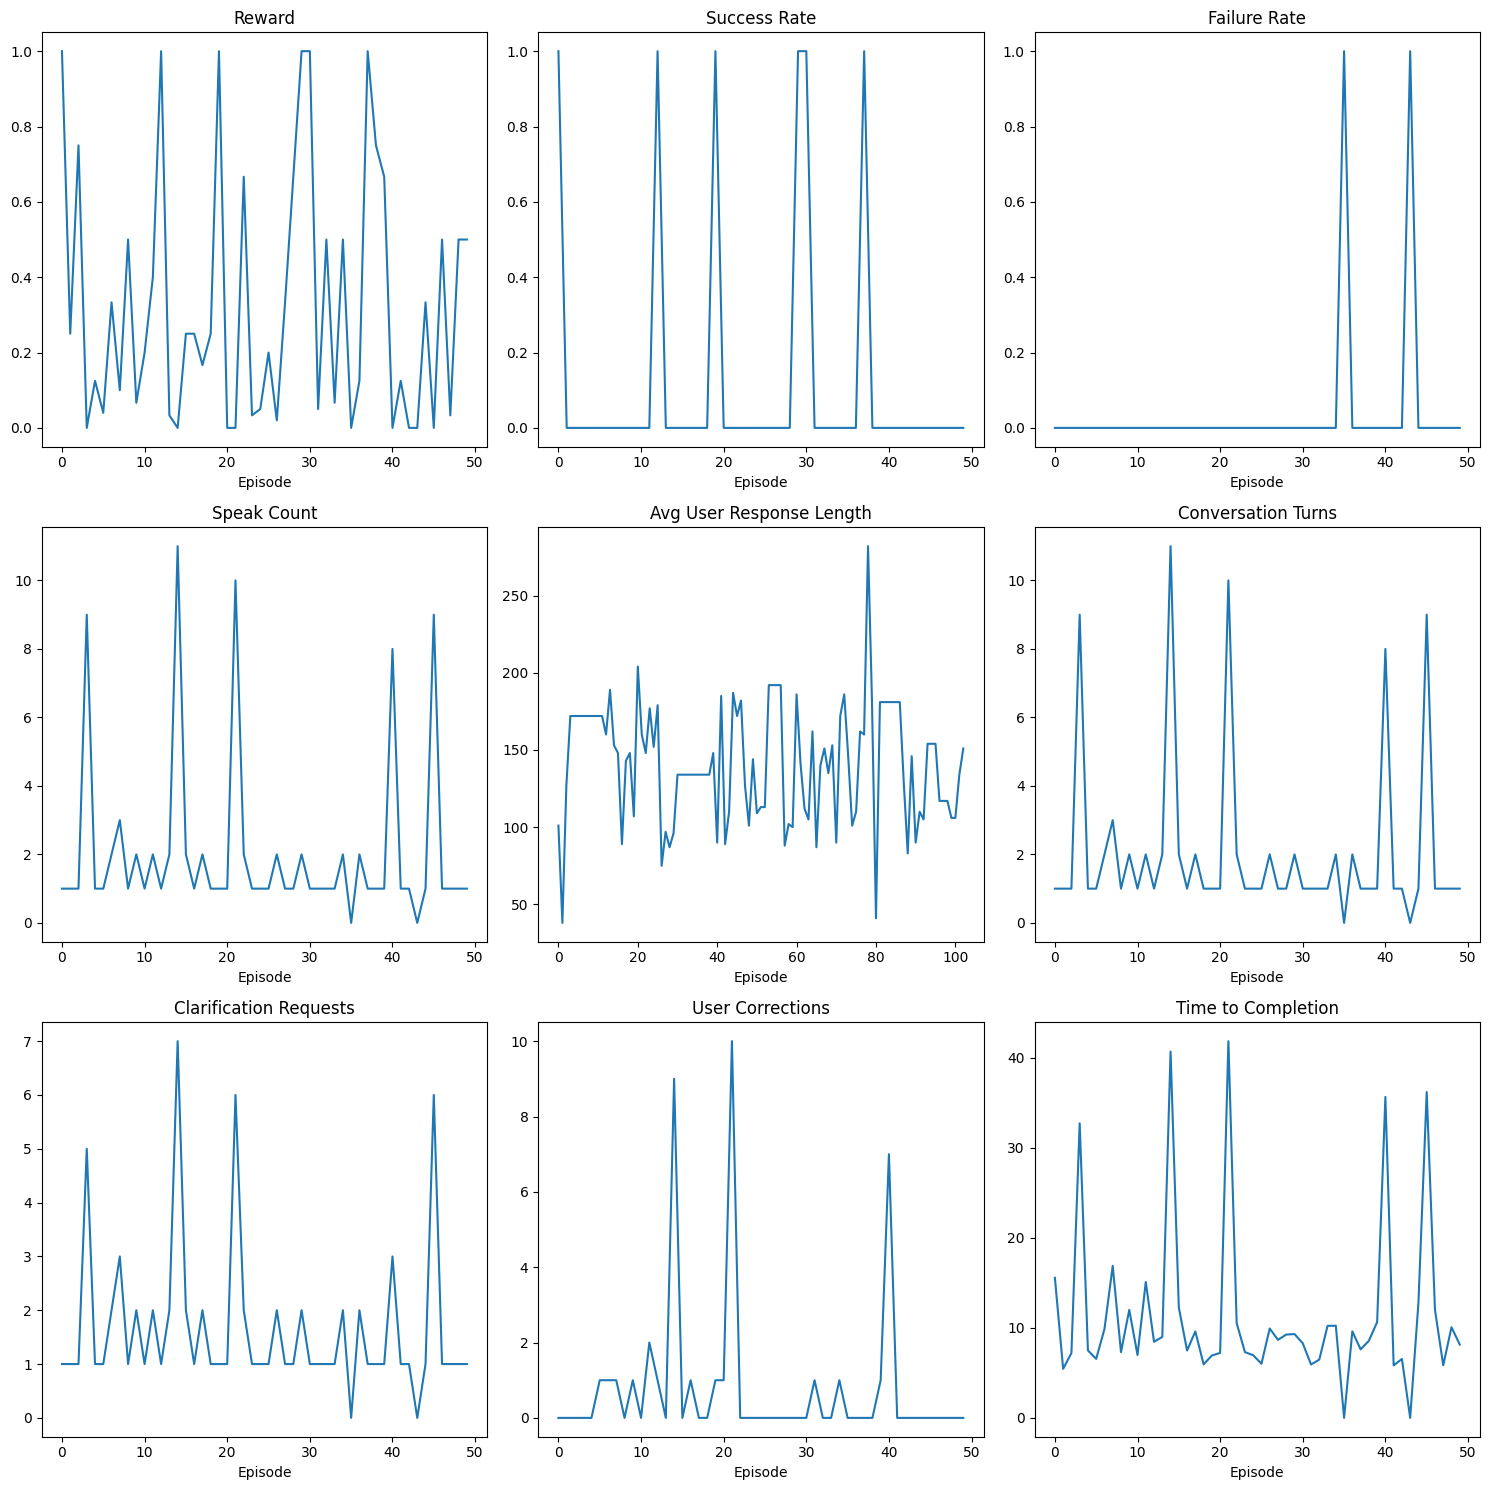

In [112]:
results = run_episodes(prompt_respact, llm, model, user_profile, n=50)